# Pre Processing

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTrain+.txt",header=None, names=col_names)
data_test = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTest+.txt",header=None, names=col_names)


In [ ]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
data.drop(['difficulty_level'],axis=1,inplace=True)
data_test.drop(['difficulty_level'],axis=1,inplace=True)
data.shape

(125973, 42)

In [ ]:
data['label'].value_counts()
data_test['label'].value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
loadmodule            2
udpstorm              2
sqlattack             2
phf                   2
worm                  2
imap                  1
Name: label, dtype: int64

In [ ]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
change_label(data)
change_label(data_test)

In [ ]:
data.label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

In [ ]:
data_test.label.value_counts()

normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: label, dtype: int64

In [ ]:
data.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)
data_test.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)

In [ ]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


# Encoding

In [ ]:
pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 5.1 MB/s 


In [ ]:
import category_encoders
from category_encoders import LeaveOneOutEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
features = ["protocol_type", "service", "flag"]
targ_enc = LeaveOneOutEncoder(cols=features)
targ_enc.fit(data[features], data['label'])
    
data = data.join(targ_enc.transform(data[features]).add_suffix('_targ'))
data_test = data_test.join(targ_enc.transform(data_test[features]).add_suffix('_targ'))
    
newdata = data.drop(features, axis=1)
newdata_test = data_test.drop(features, axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
newdata.shape

(125973, 42)

# Scaling

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
numeric_col = newdata.select_dtypes(include='number').columns

In [ ]:
rbs_scaler = RobustScaler()
for i in numeric_col:
    arr = newdata[i]
    arr = np.array(arr)
    newdata[i] = rbs_scaler.fit_transform(arr.reshape(len(arr),1))
    arr2 = newdata_test[i]
    arr2 = np.array(arr2)
    newdata_test[i] = rbs_scaler.transform(arr2.reshape(len(arr2),1))

# X Y Dataset 

In [ ]:
from tensorflow import keras 

In [ ]:
Y_train = newdata.label
X_train = newdata.drop("label",1)
Y_test = newdata_test.label
X_test = newdata_test.drop("label",1)

#change data to 1024 columns to enable reshape

currdata = X_train
tempdata = pd.concat([currdata, currdata, currdata, currdata.iloc[:, :5]], axis = 1)
finaldata = pd.concat([tempdata, tempdata,tempdata,tempdata,tempdata,tempdata,tempdata,tempdata], axis = 1)
X_train = finaldata

#add test data specifically
X_train = X_train.values.reshape(X_train.shape[0], 32, 32, 1)

#change data to 1024 columns to enable reshape
currdata = X_test
tempdata = pd.concat([currdata, currdata, currdata, currdata.iloc[:, :5]], axis = 1)
finaldata = pd.concat([tempdata, tempdata,tempdata,tempdata,tempdata,tempdata,tempdata,tempdata], axis = 1)
X_test = finaldata

# preprocess the validation data
X_test = X_test.values.reshape(X_test.shape[0], 32, 32, 1)

In [ ]:
X_train.shape

(125973, 32, 32, 1)

In [ ]:
Y_train.shape

(125973,)


# CNN Preprocessing

In [ ]:
# currdata = X_train
# tempdata = pd.concat([currdata, currdata, currdata, currdata.iloc[:, :5]], axis = 1)
# finaldata = pd.concat([tempdata, tempdata,tempdata,tempdata,tempdata,tempdata,tempdata,tempdata], axis = 1)
# finaldata.shape

In [ ]:
# finaldata

# CNN Model

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow import stack
from matplotlib import pyplot as plt

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))

# add second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# add one max pooling layer 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# add one dropout layer
model.add(layers.Dropout(0.25))

# add flatten layer
model.add(layers.Flatten())

# add dense layer
model.add(layers.Dense(128, activation='relu'))

# add another dropout layer
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Epoch 1/5
6299/6299 [==============================] - 380s 60ms/step - loss: 0.0311 - accuracy: 0.9666 - val_loss: 0.0226 - val_accuracy: 0.9767
Epoch 2/5
6299/6299 [==============================] - 380s 60ms/step - loss: 0.0234 - accuracy: 0.9758 - val_loss: 0.0243 - val_accuracy: 0.9756
Epoch 3/5
6299/6299 [==============================] - 378s 60ms/step - loss: 0.0234 - accuracy: 0.9762 - val_loss: 0.0214 - val_accuracy: 0.9783
Epoch 4/5
6299/6299 [==============================] - 379s 60ms/step - loss: 0.0247 - accuracy: 0.9751 - val_loss: 0.0262 - val_accuracy: 0.9737
Epoch 5/5
6299/6299 [==============================] - 378s 60ms/step - loss: 0.0246 - accuracy: 0.9753 - val_loss: 0.0228 - val_accuracy: 0.9772


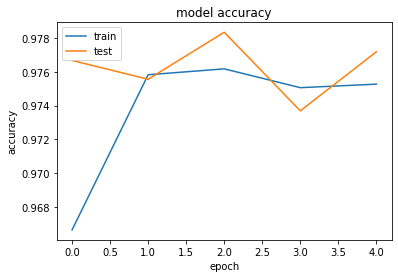

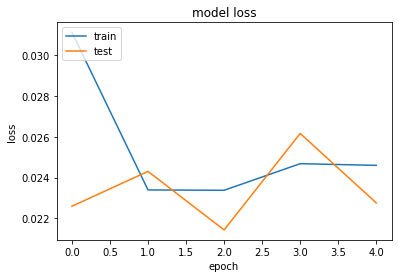

In [ ]:
#fit model for X_train and Y_train
history = model.fit(X_train, Y_train, batch_size = 16, epochs = 5, validation_split=0.2)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', accuracy[1])

Test accuracy: 0.7463626861572266


# Classification

In [ ]:
from sklearn.metrics import accuracy_score
# make predictions on the test set
yhat = model.predict(X_test)
yhat_pred=[]
for val in yhat:
    if (val<0.5):
        yhat_pred.append(0)
    else:
        yhat_pred.append(1)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat_pred)
print(acc)

0.7463626685592619


# Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, yhat_pred)

array([[8969,  742],
       [4976, 7857]])

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(Y_test, yhat_pred))
print(recall_score(Y_test, yhat_pred))

0.9137108966158856
0.6122496688225668


In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_test, yhat_pred)

0.7332026875699887

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.833


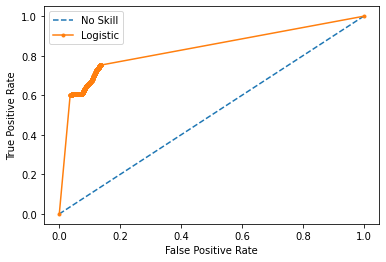

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as pyplot

ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = model.predict(X_test)
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.733 auc=0.903


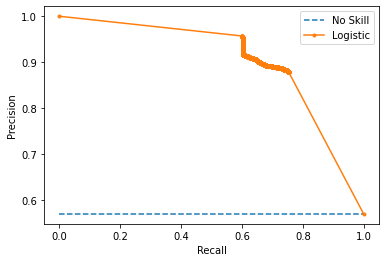

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict(X_test)

lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()